In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import math

#import stuff for gradCAM
import matplotlib.cm as cm
from IPython.display import Image

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.3.0


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

No GPU


2022-01-27 11:44:48.680094: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-27 11:44:48.700778: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2419200000 Hz
2022-01-27 11:44:48.701553: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56108f40de10 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-01-27 11:44:48.701577: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


In [3]:
# define a callback

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', 
                                             patience = 15, 
                                             restore_best_weights = True)

In [5]:
#build data generators for training and validaton

split = 0.2

total_train = 84
total_val = 20


# Define dirs and files
train_data_dir = '../data/openmv'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 45,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 16

#set Image size (RGB so imshape is 3)
pix_dim = 320
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    color_mode = 'rgb',
                                                    target_size = imsize,
                                                    subset='training')

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_directory(train_data_dir, # same directory as training data,
                                                        batch_size = batch_size,
                                                        class_mode = 'categorical',
                                                        color_mode = 'rgb',
                                                        target_size = imsize,
                                                        subset='validation')

Found 84 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [6]:
# define the metrics
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

In [7]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=imshape),
    layers.Conv2D(filters=16, kernel_size=3, strides = 2, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Conv2D(32, 3, strides = 2, padding='same', activation='relu'),
    layers.MaxPool2D(),

    layers.Conv2D(64, 3, strides = 2, padding='same', activation='relu'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2,activation = "softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

In [8]:
#build the model
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = acc_metric)

In [9]:
#train the model
history = model.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 40,
                    validation_steps =  total_val // batch_size,
                    callbacks =[callbacks])

Epoch 1/40
5/5 [==============================] - 1s 257ms/step - loss: 0.7233 - acc: 0.3529 - val_loss: 0.6916 - val_acc: 0.5000
Epoch 2/40
5/5 [==============================] - 1s 213ms/step - loss: 0.6996 - acc: 0.5000 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 3/40
5/5 [==============================] - 1s 205ms/step - loss: 0.7020 - acc: 0.4265 - val_loss: 0.6717 - val_acc: 0.6250
Epoch 4/40
5/5 [==============================] - 1s 204ms/step - loss: 0.7350 - acc: 0.3676 - val_loss: 0.6938 - val_acc: 0.4375
Epoch 5/40
5/5 [==============================] - 1s 230ms/step - loss: 0.6868 - acc: 0.5441 - val_loss: 0.6942 - val_acc: 0.5000
Epoch 6/40
5/5 [==============================] - 1s 217ms/step - loss: 0.6919 - acc: 0.5000 - val_loss: 0.6762 - val_acc: 0.5625
Epoch 7/40
5/5 [==============================] - 1s 223ms/step - loss: 0.6945 - acc: 0.4853 - val_loss: 0.6807 - val_acc: 0.5625
Epoch 8/40
5/5 [==============================] - 1s 211ms/step - loss: 0.6982 - acc: 0.47

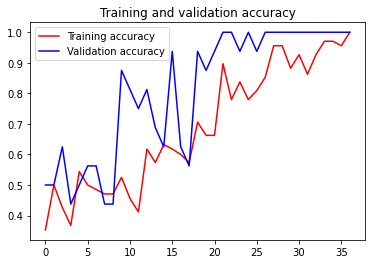

<Figure size 432x288 with 0 Axes>

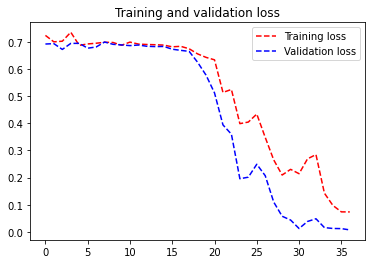

<Figure size 432x288 with 0 Axes>

In [10]:
#look at the metrics from training
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [11]:
#save the model
filepath = './models/MokaPotNet_tf23_cat_OMV'
model.save(filepath)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


2022-01-27 11:46:08.069726: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/MokaPotNet_tf23_cat_OMV/assets


In [12]:
# #quantize

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]



num_calibration_steps = 1
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        # Get sample input data as a numpy array in a method of your choosing.
        ## Ideally we should do a validation calibration but we are using all of the training data for max acc
#         x =np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
        x =np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
        print(x.shape)
        yield [x]
converter.representative_dataset = representative_dataset_gen


converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8

tflite_model = converter.convert()

with open('MokaPotNet_cat_OMV.tflite','wb') as f:
    f.write(tflite_model)

interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

# import pathlib

# tflite_models_dir = pathlib.Path("TFLmodels/")
# tflite_models_dir.mkdir(exist_ok=True, parents=True)


# tflite_model_file = tflite_models_dir/"MokePotNet.tflite"
# tflite_model_file.write_bytes(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmpoaoysiz7/assets


2022-01-27 11:46:09.353473: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-01-27 11:46:09.353558: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-01-27 11:46:09.355066: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:816] Optimization results for grappler item: graph_to_optimize
2022-01-27 11:46:09.355078: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:818]   function_optimizer: function_optimizer did nothing. time = 0.002ms.
2022-01-27 11:46:09.355081: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:818]   function_optimizer: function_optimizer did nothing. time = 0ms.
2022-01-27 11:46:09.387742: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:313] Ignored output_format.
2022-01-27 11:46:09.387771: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ig

(84, 320, 320, 3)
input:  <class 'numpy.int8'>
output:  <class 'numpy.int8'>
